[*********************100%***********************]  1 of 1 completed


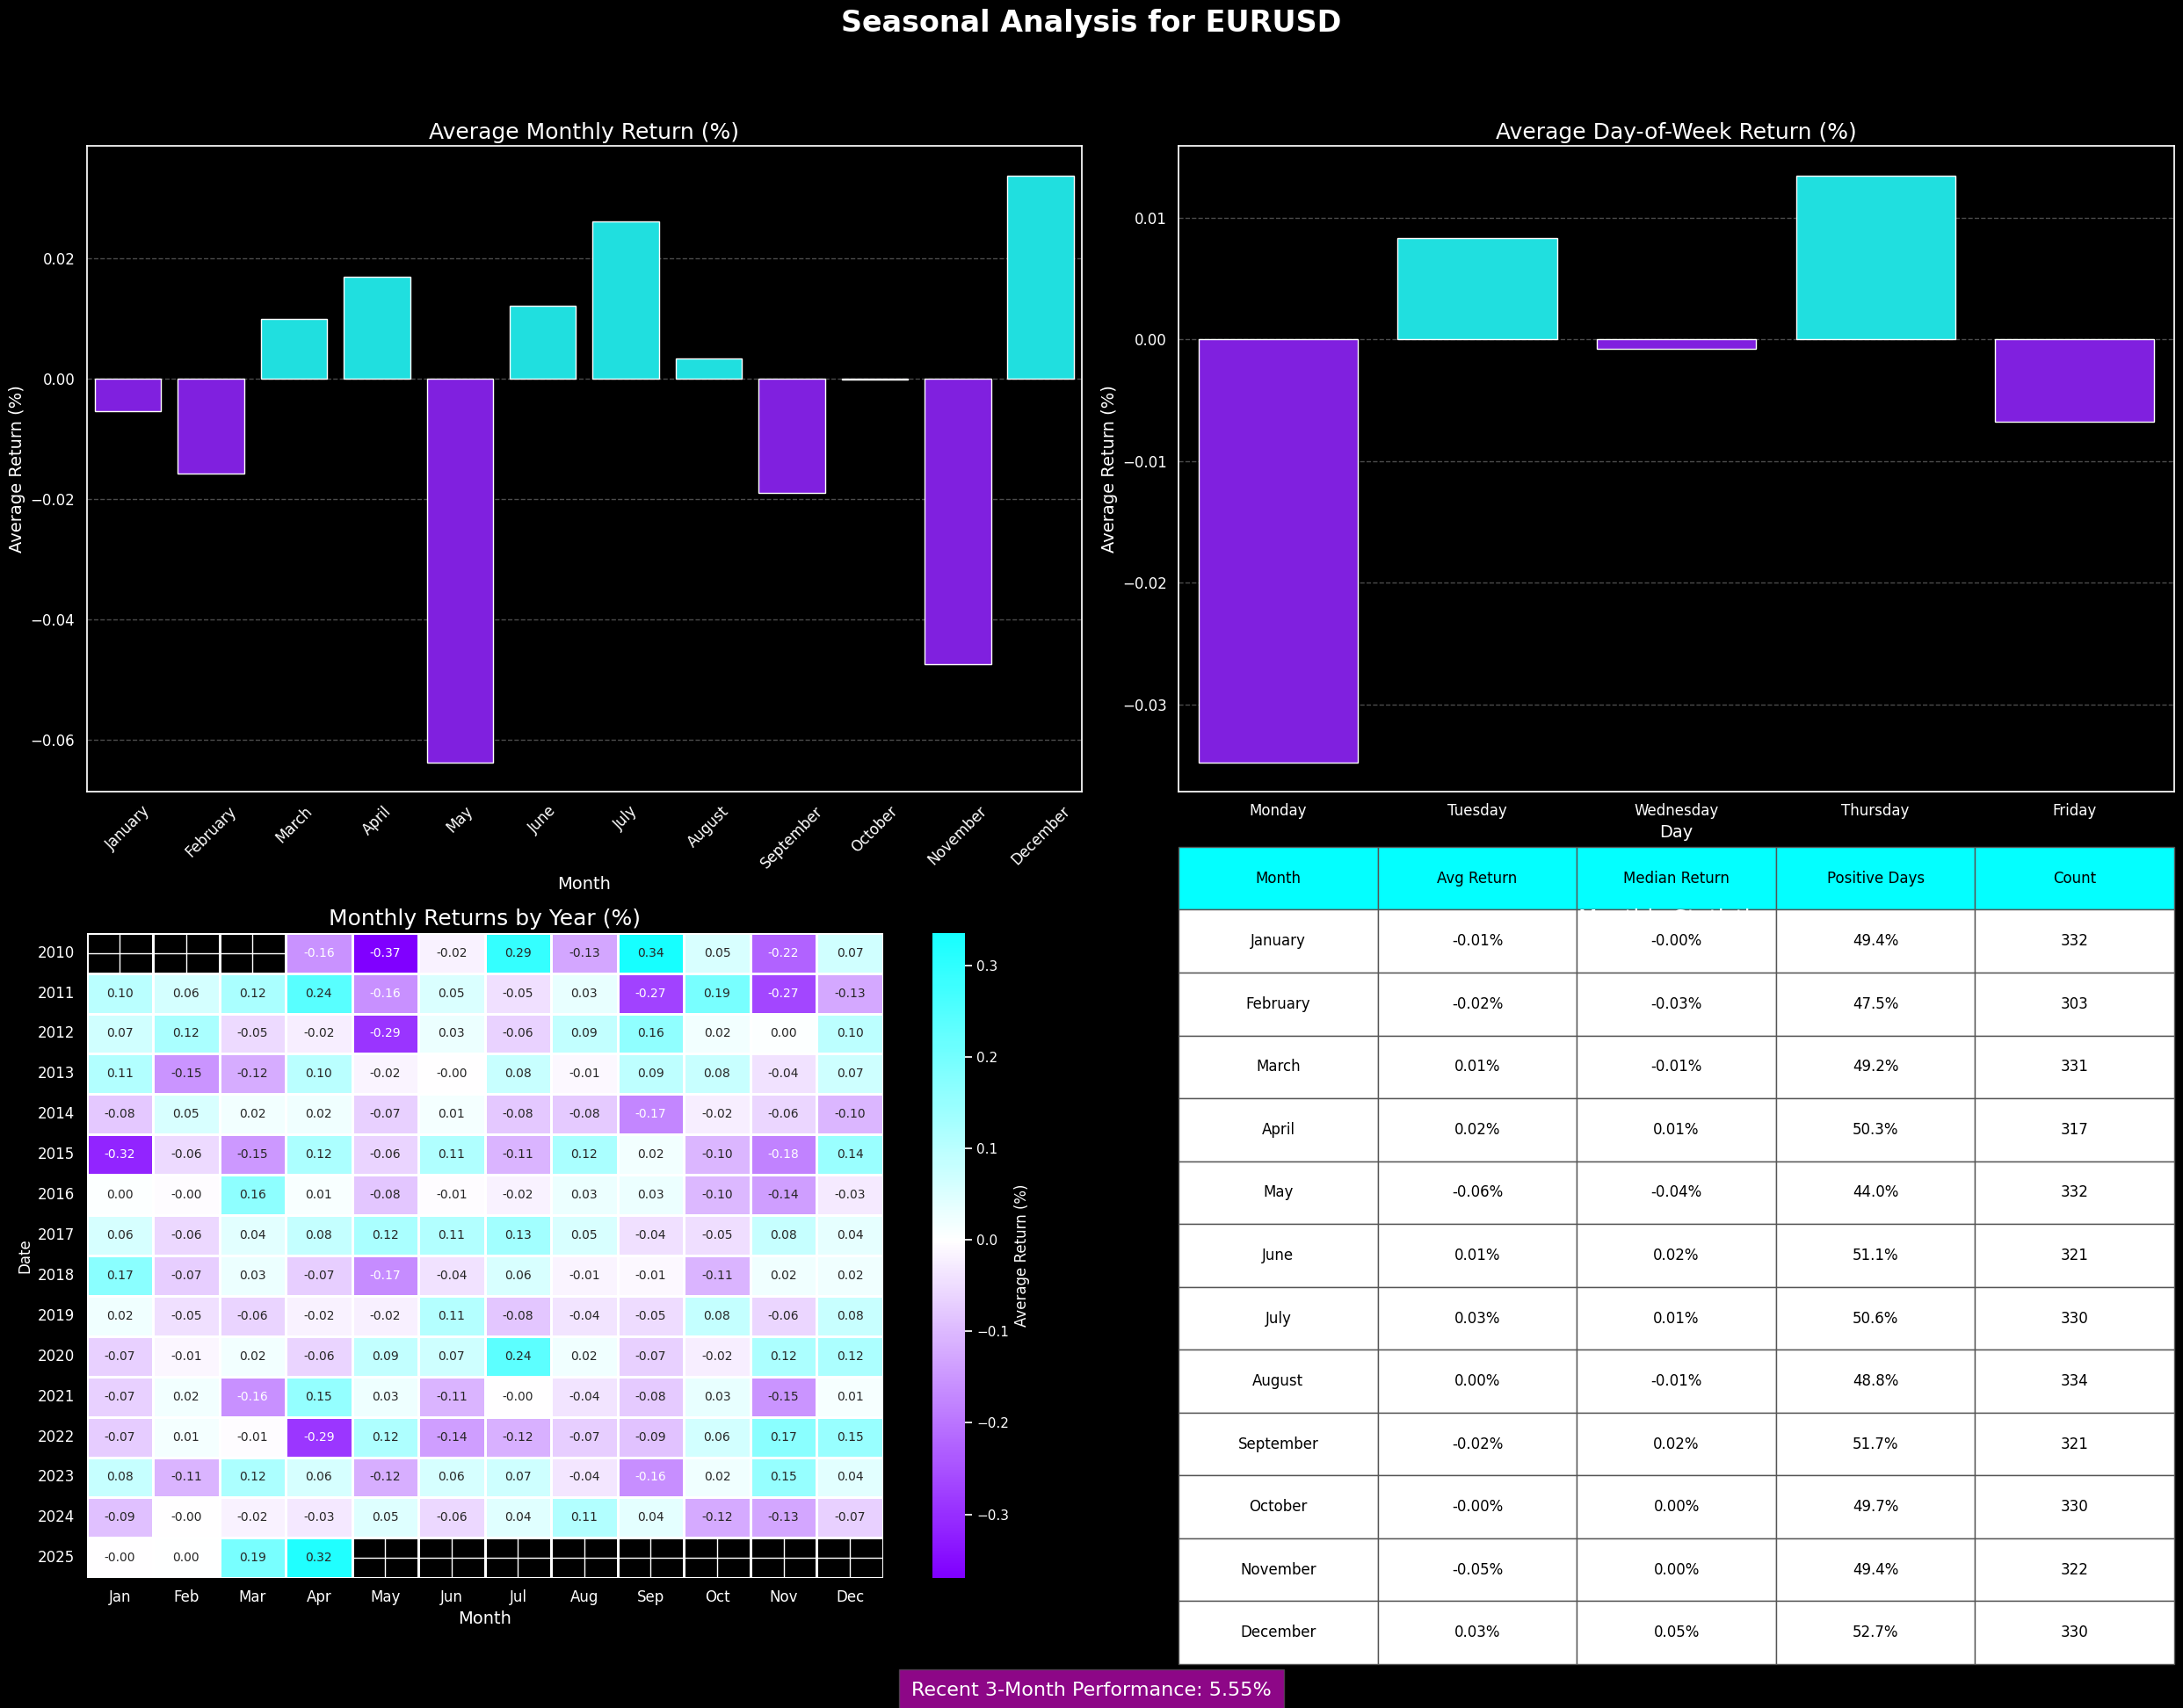

(           Average Return (%)  Median Return (%)  Positive Days (%)  Count
 January             -0.005482          -0.000569          49.397590    332
 February            -0.015753          -0.029491          47.524752    303
 March                0.009876          -0.013053          49.244713    331
 April                0.016825           0.011732          50.314465    317
 May                 -0.063734          -0.038378          43.975904    332
 June                 0.011985           0.019343          51.090343    321
 July                 0.026036           0.009000          50.606061    330
 August               0.003323          -0.006366          48.802395    334
 September           -0.018962           0.017674          51.713396    321
 October             -0.000245           0.000000          49.696970    330
 November            -0.047403           0.000000          49.378882    322
 December             0.033680           0.051019          52.727273    330,
           

In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap

def forex_seasonal_analysis(pair):
    if pair not in FOREX_PAIRS:
        print(f"Error: {pair} is not in the list of major forex pairs.")
        return

    symbol = f"{pair[:3]}{pair[3:]}=X"

    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*15)

    data = yf.download(symbol, start=start_date, end=end_date)

    if len(data) == 0:
        print(f"Error: No data found for {pair}")
        return

    data['Return'] = data['Close'].pct_change() * 100

    data['Month'] = data.index.month
    data['Weekday'] = data.index.weekday
    data['Year'] = data.index.year

    monthly_returns = pd.DataFrame({
        'Average Return (%)': data.groupby('Month')['Return'].mean(),
        'Median Return (%)': data.groupby('Month')['Return'].median(),
        'Positive Days (%)': data.groupby('Month')['Return'].apply(lambda x: (x > 0).mean() * 100),
        'Count': data.groupby('Month')['Return'].count()
    })

    month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    monthly_returns.index = [month_names[m-1] for m in monthly_returns.index]

    weekday_returns = pd.DataFrame({
        'Average Return (%)': data.groupby('Weekday')['Return'].mean(),
        'Median Return (%)': data.groupby('Weekday')['Return'].median(),
        'Positive Days (%)': data.groupby('Weekday')['Return'].apply(lambda x: (x > 0).mean() * 100),
        'Count': data.groupby('Weekday')['Return'].count()
    })

    weekday_returns.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    recent_data = data[data.index >= datetime.now() - timedelta(days=90)]
    recent_return = recent_data['Close'].iloc[-1] / recent_data['Close'].iloc[0] - 1 if len(recent_data) > 0 else 0
    month_pivot = pd.pivot_table(
        data,
        index=data.index.year,
        columns=data.index.month,
        values='Return',
        aggfunc='mean'
        )
    yearly_monthly_returns = month_pivot.copy()
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    col_mapping = {}
    for i, month_num in enumerate(range(1, 13)):
        if month_num in yearly_monthly_returns.columns:
            col_mapping[month_num] = month_abbr[i]
    yearly_monthly_returns = yearly_monthly_returns.rename(columns=col_mapping)

    display_results(pair, monthly_returns, weekday_returns, yearly_monthly_returns, recent_return)

    return monthly_returns, weekday_returns, yearly_monthly_returns

def display_results(pair, monthly_returns, weekday_returns, yearly_monthly_returns, recent_return):
    plt.style.use('dark_background')
    plt.figure(figsize=(25, 20))
    plt.subplots_adjust(hspace=3, wspace=0.4)
    plt.suptitle(f'Seasonal Analysis for {pair}', fontsize=24, weight='bold', y=0.98)

    plt.subplot(2, 2, 1)
    colors = ['#8000FF' if x < 0 else '#00FFFF' for x in monthly_returns['Average Return (%)']]
    ax1 = sns.barplot(x='index', y='Average Return (%)',
                     data=monthly_returns.reset_index(),
                     hue='index', palette=colors, legend=False)
    plt.title('Average Monthly Return (%)', fontsize=18)
    plt.ylabel('Average Return (%)', fontsize=14)
    plt.xlabel('Month', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.subplot(2, 2, 2)
    colors = ['#8000FF' if x < 0 else '#00FFFF' for x in weekday_returns['Average Return (%)']]
    ax2 = sns.barplot(x='index', y='Average Return (%)',
                     data=weekday_returns.reset_index(),
                     hue='index', palette=colors, legend=False)
    plt.title('Average Day-of-Week Return (%)', fontsize=18)
    plt.ylabel('Average Return (%)', fontsize=14)
    plt.xlabel('Day', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.subplot(2, 2, 3)
    cmap = LinearSegmentedColormap.from_list("CyanPurple", ["#8000FF", "white", "#00FFFF"])
    sns.heatmap(yearly_monthly_returns, cmap=cmap, center=0, annot=True,
                fmt='.2f', linewidths=.8, annot_kws={"size": 10},
                cbar_kws={'label': 'Average Return (%)'})
    plt.title('Monthly Returns by Year (%)', fontsize=18)
    plt.xlabel('Month', fontsize=14)
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(ticks=np.arange(12)+0.5, labels=month_abbr, fontsize=12)
    plt.yticks(fontsize=12)

    plt.subplot(2, 2, 4)
    cell_text = []
    for idx, row in monthly_returns.iterrows():
        cell_text.append([
            idx,
            f"{row['Average Return (%)']:.2f}%",
            f"{row['Median Return (%)']:.2f}%",
            f"{row['Positive Days (%)']:.1f}%",
            f"{int(row['Count'])}"
        ])

    column_labels = ['Month', 'Avg Return', 'Median Return', 'Positive Days', 'Count']
    table = plt.table(cellText=cell_text, colLabels=column_labels, loc='center',
                     cellLoc='center', colColours=['#03ffff']*5)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.8)
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color='black')
        cell.set_edgecolor('#555555')
    plt.axis('off')
    plt.title('Monthly Statistics', fontsize=18)
    if isinstance(recent_return, pd.Series):
        recent_return = recent_return.iloc[0]
    plt.figtext(0.5, 0.02, f"Recent 3-Month Performance: {recent_return*100:.2f}%",
                ha="center", fontsize=16, color='white',
                bbox={"facecolor":"#ca0ac1", "alpha":0.7, "pad":10, "edgecolor":"#555555"})

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

FOREX_PAIRS = [
    "EURUSD", "USDJPY", "GBPUSD", "AUDUSD", "USDCHF",
    "NZDUSD", "USDCAD", "EURJPY", "EURGBP", "EURCHF",
    "AUDJPY", "GBPJPY", "CHFJPY", "EURAUD", "EURNZD",
    "GBPAUD", "GBPCHF", "AUDCAD", "AUDNZD", "NZDCAD"
]

forex_seasonal_analysis('EURUSD')